# Titanic ML Project

by: Peter Ivanov

## Data Loading

In [7]:
# Importing necessary Python libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We'll need this to split the train and test data
from sklearn.model_selection import train_test_split

# We'll need this to encode the categorical features into numerical ones
from sklearn.preprocessing import LabelEncoder

# We'll use random forests classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# We'll use some scoring 
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [8]:
df = pd.read_csv("train.csv", index_col="PassengerId")

In [9]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


## Data Wrangling

Initial description of the numerical data:

In [10]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Checking out the data types:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


All numerical data looks good. There's nothing needed to be converted from strings to numbers.

There seem to be some missing values for age, cabin and ports of embarkation. These will be handled in **Data Cleaning** section:

In [12]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

## Feature Engineering

It makes sense to separate field _Name_ into several others. Following fields would be simple to do:

1. Surname
2. Title (Mr., Mrs., Miss., Master.)

Then determining _Given name_ is getting tricky. There are certain passengers (female) who have their spouses' given names included in this string. It seems that they can be identified by having their full _maiden names_ in parentheses.

See example:
`"Bishop, Mrs. Dickinson H (Helen Walton)"` translates to `Mrs. Helen Bishop`, maiden name `Helen Walton`, spouse's name: `Dickinson H Bishop`

It actually makes sense to only keep _Given name_. The _Husband name_ and _Maiden name_ information we just don't care about.

_Given name_ can be extracted in two ways:

1. for women that contain parentheses in their _Name_ we can take the first word after the first left parenthesis
2. for everybody else we can take first word after the title

There are 129 women with parentheses in _Name_:

In [13]:
df[["Name"]][(df["Name"].str.contains("\(.*\)")) & (df["Sex"]=="female")]

,Name
PassengerId,
2,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"
10,"Nasser, Mrs. Nicholas (Adele Achem)"
16,"Hewlett, Mrs. (Mary D Kingcome)"
...,...
872,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)"
875,"Abelson, Mrs. Samuel (Hannah Wizosky)"
880,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)"


In [14]:
df["Name"].str.split(',', n=1, expand=True)[0].head(50)

PassengerId
1             Braund
2            Cumings
3          Heikkinen
4           Futrelle
5              Allen
6              Moran
7           McCarthy
8            Palsson
9            Johnson
10            Nasser
11         Sandstrom
12           Bonnell
13       Saundercock
14         Andersson
15           Vestrom
16           Hewlett
17              Rice
18          Williams
19     Vander Planke
20        Masselmani
21            Fynney
22           Beesley
23           McGowan
24            Sloper
25           Palsson
26           Asplund
27              Emir
28           Fortune
29           O'Dwyer
30          Todoroff
31         Uruchurtu
32           Spencer
33             Glynn
34           Wheadon
35             Meyer
36         Holverson
37             Mamee
38              Cann
39     Vander Planke
40     Nicola-Yarred
41             Ahlin
42            Turpin
43            Kraeff
44           Laroche
45           Devaney
46            Rogers
47            Lennon
4

In [15]:
# Expansion of "Surname"
df["Surname"] = df["Name"].str.split(',', n=1, expand=True)[0]

df["Surname"].value_counts()

Andersson    9
Sage         7
Goodwin      6
Panula       6
Skoog        6
            ..
Douglas      1
Stranden     1
Levy         1
Eklund       1
Windelov     1
Name: Surname, Length: 667, dtype: int64

In [16]:
# Expansion of "Title"
# It was not enough to just take what was next to ","
# It had to be limited also with the trailing "."
df["Title"] = (df["Name"].str.split(',', n=2, expand=True)[1]
                   .str.split('.', n=1, expand=True)[0]
                   .str.lstrip())

df["Title"].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Lady              1
Jonkheer          1
Ms                1
Sir               1
Don               1
Capt              1
the Countess      1
Mme               1
Name: Title, dtype: int64

In [17]:
# Keeping the third word for everybody (that's one after surname and title)
df["Given name"] = (df["Name"].str.split(',', n=2, expand=True)[1]
    .str.split('.', n=2, expand=True)[1]
    .str.split(n=1, expand=True)[0])

df["Given name"].value_counts()

William    48
John       31
Thomas     19
George     16
Charles    16
           ..
Bernt       1
Helmina     1
Clear       1
Luise       1
Konrad      1
Name: Given name, Length: 441, dtype: int64

In [18]:
# Now the "Given name" for the married women:
# Getting first word (n=1)[0] from second part (n=2)[1] of the string split by "("
df.loc[
    (df["Name"].str.contains("\(.*\)")) & (df["Sex"]=="female"),
    "Given name"
] = df.loc[
    (df["Name"].str.contains("\(.*\)")) & (df["Sex"]=="female"),
    "Name"
].str.split("(", n=2, expand=True)[1].str.split(n=1, expand=True)[0]

df["Given name"].value_counts()

William    35
John       25
Anna       14
George     14
Thomas     13
           ..
Imanita     1
Jacques     1
Helmina     1
Clear       1
Konrad      1
Name: Given name, Length: 471, dtype: int64

In [19]:
df[["Title", "Given name", "Surname", "Name"]].head(50)

,Title,Given name,Surname,Name
PassengerId,,,,
1,Mr,Owen,Braund,"Braund, Mr. Owen Harris"
2,Mrs,Florence,Cumings,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
3,Miss,Laina,Heikkinen,"Heikkinen, Miss. Laina"
4,Mrs,Lily,Futrelle,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
5,Mr,William,Allen,"Allen, Mr. William Henry"
6,Mr,James,Moran,"Moran, Mr. James"
7,Mr,Timothy,McCarthy,"McCarthy, Mr. Timothy J"
8,Master,Gosta,Palsson,"Palsson, Master. Gosta Leonard"
9,Mrs,Elisabeth,Johnson,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"


In [20]:
# Droping the column "Name" - we don't need it anymore

df.drop(columns=["Name", "Ticket"], inplace=True)

df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Surname,Title,Given name
PassengerId,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN,S,Braund,Mr,Owen
2,1,1,female,38.0,1,0,71.2833,C85,C,Cumings,Mrs,Florence
3,1,3,female,26.0,0,0,7.9250,NaN,S,Heikkinen,Miss,Laina
4,1,1,female,35.0,1,0,53.1000,C123,S,Futrelle,Mrs,Lily
5,0,3,male,35.0,0,0,8.0500,NaN,S,Allen,Mr,William
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,13.0000,NaN,S,Montvila,Rev,Juozas
888,1,1,female,19.0,0,0,30.0000,B42,S,Graham,Miss,Margaret
889,0,3,female,NaN,1,2,23.4500,NaN,S,Johnston,Miss,Catherine


In [21]:
df[["Title", "Given name", "Surname"]].isna().sum()

Title         0
Given name    0
Surname       0
dtype: int64

Looks good.

## Data Exploration

**Question**: _"How many people named Jack have been on board?"_

**Answer**: _Zero._

In [22]:
df["Given name"][df["Given name"]=="Jack"].sum()

0

Pair plot doesn't really reveal any insights towards chance to survival.

Here is what I could get out of it:

1. Passengers from 3rd class are most likely to die.
2. Lower fare passengers are most likely to die.

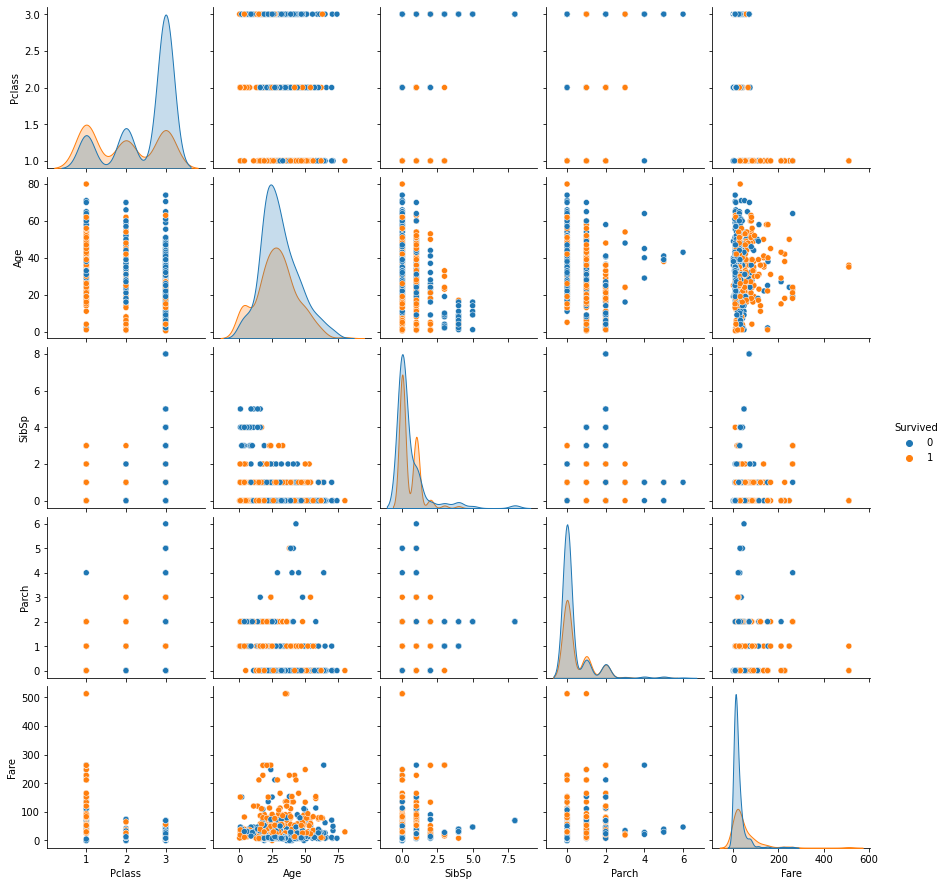

In [23]:
sns.pairplot(data=df, hue="Survived")

## Train-Validation-Split

First we need to create _numpy arrays_ from the _pandas dataframe_:

In [24]:
# Extracting label as numpy array from dataframe

# The convention is to mark it with lowercase "y" - it's a vector y
y = df["Survived"].values

In [25]:
# Extraction of the rest of the "features" form dataframe

# Convention is to use CAPITAL X as it indicates matrix (as numpy array)
X = df.loc[:, df.columns != "Survived"].values

In [26]:
y.shape, X.shape

((891,), (891, 11))

Looks good. Now we split the _train_ and _test_ sets.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=117)

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((668, 11), (668,), (223, 11), (223,))

Now I'd like to convert it back to _pandas_ dataframes, so I can do some **data cleaning**.

In [29]:
type_dict= {
    "Pclass": np.int64,
    "Age": np.float64,
    "SibSp": np.int64,
    "Parch": np.int64,
    "Fare": np.float64,
    "Survived": np.int64
}

df_train = pd.DataFrame(X_train, columns=df.columns[1:])
df_test = pd.DataFrame(X_test, columns=df.columns[1:])

df_train["Survived"] = y_train
df_test["Survived"] = y_test

df_train = df_train.astype(type_dict)
df_test = df_test.astype(type_dict)

In [30]:
df_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Surname,Title,Given name,Survived
0,3,male,28.0,0,0,56.4958,NaN,S,Ling,Mr,Lee,0
1,3,male,25.0,1,0,7.7750,NaN,S,Petterson,Mr,Johan,0
2,3,female,NaN,8,2,69.5500,NaN,S,Sage,Miss,Dorothy,0
3,1,male,62.0,0,0,26.5500,C87,S,Stead,Mr,William,0
4,1,male,35.0,0,0,512.3292,B101,C,Lesurer,Mr,Gustave,1
...,...,...,...,...,...,...,...,...,...,...,...,...
663,1,male,49.0,1,0,56.9292,A20,C,Duff Gordon,Sir,Cosmo,1
664,1,female,41.0,0,0,134.5000,E40,C,Burns,Miss,Elizabeth,1
665,3,male,22.0,0,0,9.0000,NaN,S,Waelens,Mr,Achille,0
666,3,male,22.0,0,0,8.0500,NaN,S,Barton,Mr,David,0


In [31]:
df_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Surname,Title,Given name,Survived
0,1,male,38.0,1,0,90.0000,C93,S,Hoyt,Mr,Frederick,1
1,1,male,48.0,1,0,76.7292,D33,C,Harper,Mr,Henry,1
2,3,male,21.0,0,0,8.0500,NaN,S,Cann,Mr,Ernest,0
3,3,male,17.0,1,1,7.2292,NaN,C,Elias,Mr,Joseph,0
4,3,female,22.0,0,0,7.7500,NaN,Q,Connolly,Miss,Kate,1
...,...,...,...,...,...,...,...,...,...,...,...,...
218,1,female,38.0,1,0,71.2833,C85,C,Cumings,Mrs,Florence,1
219,1,male,61.0,0,0,33.5000,B19,S,Van der hoef,Mr,Wyckoff,0
220,3,male,30.0,0,0,7.2250,NaN,C,Attalah,Mr,Sleiman,0
221,2,male,1.0,2,1,39.0000,F4,S,Becker,Master,Richard,1


## Data cleaning

We've got three columns with missing values:

1. Age
2. Cabin
3. Embarked

In [32]:
df_train.isna().sum()

Pclass          0
Sex             0
Age           133
SibSp           0
Parch           0
Fare            0
Cabin         520
Embarked        1
Surname         0
Title           0
Given name      0
Survived        0
dtype: int64

In [33]:
df_test.isna().sum()

Pclass          0
Sex             0
Age            44
SibSp           0
Parch           0
Fare            0
Cabin         167
Embarked        1
Surname         0
Title           0
Given name      0
Survived        0
dtype: int64

### Dealing with age

We will fill the missing values based on a _Title_. Apparently there are some age range for some titles. See the _boxplot_ below:

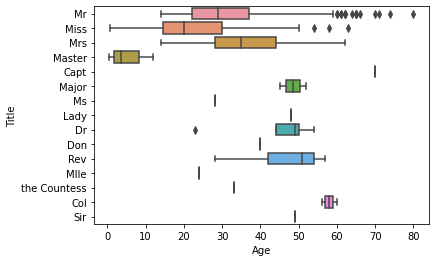

In [34]:
sns.boxplot(x="Age", y="Title", data=df_train, orient="h")

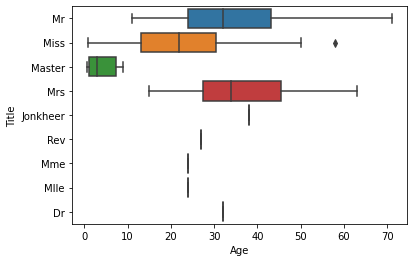

In [35]:
sns.boxplot(x="Age", y="Title", data=df_test, orient="h")

In [36]:
df_train[df_train["Age"].isna()].groupby("Title").count()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Surname,Given name,Survived
Title,,,,,,,,,,,
Dr,1,1,0,1,1,1,0,1,1,1,1
Master,3,3,0,3,3,3,0,3,3,3,3
Miss,26,26,0,26,26,26,2,26,26,26,26
Mr,91,91,0,91,91,91,8,91,91,91,91
Mrs,12,12,0,12,12,12,3,12,12,12,12


In [37]:
df_test[df_test["Age"].isna()].groupby("Title").count()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Surname,Given name,Survived
Title,,,,,,,,,,,
Master,1,1,0,1,1,1,0,1,1,1,1
Miss,10,10,0,10,10,10,0,10,10,10,10
Mr,28,28,0,28,28,28,4,28,28,28,28
Mrs,5,5,0,5,5,5,2,5,5,5,5


Computing medians over _Titles_ in train data.

In [38]:
medians_train = df_train["Age"].groupby(by=df_train["Title"]).median()
medians_test = df_test["Age"].groupby(by=df_test["Title"]).median()

print(medians_train["Mr"])
print(medians_test["Mr"])

29.0
32.0


We'll fill NaNs with MEDIANs for each title:

1. Dr -> 49.0
2. Master -> 3.5
3. Miss -> 20.0
4. Mr -> 29.0
5. Mrs -> 35.0

In [39]:
df_train.loc[(df_train["Age"].isna()) & (df_train["Title"]=="Dr"), "Age"] = medians_train["Dr"]
df_train.loc[(df_train["Age"].isna()) & (df_train["Title"]=="Master"), "Age"] = medians_train["Master"]
df_train.loc[(df_train["Age"].isna()) & (df_train["Title"]=="Miss"), "Age"] = medians_train["Miss"]
df_train.loc[(df_train["Age"].isna()) & (df_train["Title"]=="Mr"), "Age"] = medians_train["Mr"]
df_train.loc[(df_train["Age"].isna()) & (df_train["Title"]=="Mrs"), "Age"] = medians_train["Mrs"]

df_test.loc[(df_test["Age"].isna()) & (df_test["Title"]=="Master"), "Age"] = medians_test["Master"]
df_test.loc[(df_test["Age"].isna()) & (df_test["Title"]=="Miss"), "Age"] = medians_test["Miss"]
df_test.loc[(df_test["Age"].isna()) & (df_test["Title"]=="Mr"), "Age"] = medians_test["Mr"]
df_test.loc[(df_test["Age"].isna()) & (df_test["Title"]=="Mrs"), "Age"] = medians_test["Mrs"]

Simple check by re-computing medians (must remain the same).

In [40]:
df_train["Age"].groupby(by=df_train["Title"]).median() == medians_train

Title
Capt            True
Col             True
Don             True
Dr              True
Lady            True
Major           True
Master          True
Miss            True
Mlle            True
Mr              True
Mrs             True
Ms              True
Rev             True
Sir             True
the Countess    True
Name: Age, dtype: bool

In [41]:
df_test["Age"].groupby(by=df_test["Title"]).median() == medians_test

Title
Dr          True
Jonkheer    True
Master      True
Miss        True
Mlle        True
Mme         True
Mr          True
Mrs         True
Rev         True
Name: Age, dtype: bool

Result

In [42]:
df_train.isna().sum()

Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Cabin         520
Embarked        1
Surname         0
Title           0
Given name      0
Survived        0
dtype: int64

In [43]:
df_test.isna().sum()

Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Cabin         167
Embarked        1
Surname         0
Title           0
Given name      0
Survived        0
dtype: int64

### Dealing with cabins

We can deal with empty cabins just by supplying a string "None". It'll act as _Cabin_ name.

In [44]:
df_train["Cabin"][df_train["Cabin"]=="None"].sum()

0

In [45]:
df_test["Cabin"][df_test["Cabin"]=="None"].sum()

0

In [46]:
df_train.fillna({"Cabin": "None"}, inplace=True)
df_test.fillna({"Cabin": "None"}, inplace=True)

In [47]:
df_train.isna().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Cabin         0
Embarked      1
Surname       0
Title         0
Given name    0
Survived      0
dtype: int64

In [48]:
df_test.isna().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Cabin         0
Embarked      1
Surname       0
Title         0
Given name    0
Survived      0
dtype: int64

### Dealing with Embarking ports

Just delete the one.

In [49]:
df_train.dropna(subset=["Embarked"], inplace=True)
df_test.dropna(subset=["Embarked"], inplace=True)

In [50]:
df_train.isna().sum().sum()

0

In [51]:
df_test.isna().sum().sum()

0

We're done with cleaning.

### Data encoding

In [52]:
# Create LabelEncoder object

le = LabelEncoder()

In [53]:
# Making a copy of the training set to save the categorical data for future reference

df_train_orig = pd.DataFrame(df_train, copy=True)

df_train_orig

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Surname,Title,Given name,Survived
0,3,male,28.0,0,0,56.4958,None,S,Ling,Mr,Lee,0
1,3,male,25.0,1,0,7.7750,None,S,Petterson,Mr,Johan,0
2,3,female,20.0,8,2,69.5500,None,S,Sage,Miss,Dorothy,0
3,1,male,62.0,0,0,26.5500,C87,S,Stead,Mr,William,0
4,1,male,35.0,0,0,512.3292,B101,C,Lesurer,Mr,Gustave,1
...,...,...,...,...,...,...,...,...,...,...,...,...
663,1,male,49.0,1,0,56.9292,A20,C,Duff Gordon,Sir,Cosmo,1
664,1,female,41.0,0,0,134.5000,E40,C,Burns,Miss,Elizabeth,1
665,3,male,22.0,0,0,9.0000,None,S,Waelens,Mr,Achille,0
666,3,male,22.0,0,0,8.0500,None,S,Barton,Mr,David,0


In [54]:
df_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Surname,Title,Given name,Survived
0,1,male,38.0,1,0,90.0000,C93,S,Hoyt,Mr,Frederick,1
1,1,male,48.0,1,0,76.7292,D33,C,Harper,Mr,Henry,1
2,3,male,21.0,0,0,8.0500,None,S,Cann,Mr,Ernest,0
3,3,male,17.0,1,1,7.2292,None,C,Elias,Mr,Joseph,0
4,3,female,22.0,0,0,7.7500,None,Q,Connolly,Miss,Kate,1
...,...,...,...,...,...,...,...,...,...,...,...,...
218,1,female,38.0,1,0,71.2833,C85,C,Cumings,Mrs,Florence,1
219,1,male,61.0,0,0,33.5000,B19,S,Van der hoef,Mr,Wyckoff,0
220,3,male,30.0,0,0,7.2250,None,C,Attalah,Mr,Sleiman,0
221,2,male,1.0,2,1,39.0000,F4,S,Becker,Master,Richard,1


In [55]:
# Encoding EVERYTHING
# Are we getting same values for i.e. Cabin = None?
# Answer: Yeah

df_train["Sex"] = le.fit_transform(df_train["Sex"])
df_train["Cabin"] = le.fit_transform(df_train["Cabin"])
df_train["Title"] = le.fit_transform(df_train["Title"])
df_train["Embarked"] = le.fit_transform(df_train["Embarked"])
df_train["Surname"] = le.fit_transform(df_train["Surname"])
df_train["Given name"] = le.fit_transform(df_train["Given name"])

df_test["Sex"] = le.fit_transform(df_test["Sex"])
df_test["Cabin"] = le.fit_transform(df_test["Cabin"])
df_test["Title"] = le.fit_transform(df_test["Title"])
df_test["Embarked"] = le.fit_transform(df_test["Embarked"])
df_test["Surname"] = le.fit_transform(df_test["Surname"])
df_test["Given name"] = le.fit_transform(df_test["Given name"])


In [56]:
df_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Surname,Title,Given name,Survived
0,3,1,28.0,0,0,56.4958,118,2,276,9,223,0
1,3,1,25.0,1,0,7.7750,118,2,380,9,190,0
2,3,0,20.0,8,2,69.5500,118,2,413,7,72,0
3,1,1,62.0,0,0,26.5500,67,2,456,9,376,0
4,1,1,35.0,0,0,512.3292,10,0,268,9,142,1
...,...,...,...,...,...,...,...,...,...,...,...,...
663,1,1,49.0,1,0,56.9292,2,0,132,13,64,1
664,1,0,41.0,0,0,134.5000,104,0,64,7,94,1
665,3,1,22.0,0,0,9.0000,118,2,491,9,2,0
666,3,1,22.0,0,0,8.0500,118,2,39,9,67,0


In [57]:
df_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Surname,Title,Given name,Survived
0,1,1,38.0,1,0,90.0000,29,2,88,6,60,1
1,1,1,48.0,1,0,76.7292,34,0,77,6,73,1
2,3,1,21.0,0,0,8.0500,52,2,30,6,53,0
3,3,1,17.0,1,1,7.2292,52,0,58,6,87,0
4,3,0,22.0,0,0,7.7500,52,1,37,3,92,1
...,...,...,...,...,...,...,...,...,...,...,...,...
218,1,0,38.0,1,0,71.2833,26,0,43,7,58,1
219,1,1,61.0,0,0,33.5000,6,2,193,6,167,0
220,3,1,30.0,0,0,7.2250,52,0,5,6,150,0
221,2,1,1.0,2,1,39.0000,50,2,11,2,137,1


### Pre-training processing

In [58]:
y_train = df_train["Survived"]
X_train = df_train.loc[:, df_train.columns != "Survived"].values

y_test = df_test["Survived"]
X_test = df_test.loc[:, df_test.columns != "Survived"].values

### Feeding our train set into the model

#### Random Forests Classifier

In [59]:
# We create random forest model object

random_forest_model = RandomForestClassifier()

In [60]:
# Training the model object with the train data

random_forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [61]:
# Testing the model with test data (making prediction)

y_pred = random_forest_model.predict(X_test)

In [62]:
# Calculating the accuracy score

accuracy_score(y_test, y_pred)

0.6306306306306306

In [63]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)

cm

array([[67, 65],
       [17, 73]])

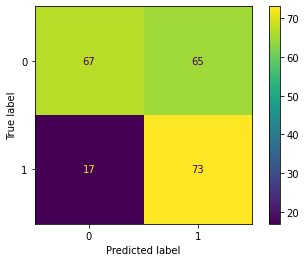

In [64]:
plot_confusion_matrix(random_forest_model, X_test, y_test)

In [65]:
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
f1 = f1_score(y_test, y_pred, average="micro")

precision, recall, f1

(0.6306306306306306, 0.6306306306306306, 0.6306306306306306)

#### k Nearest Neighbors

In [66]:
knn_model = KNeighborsClassifier(n_neighbors=13)

In [67]:
# Training KNN model

knn_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

In [68]:
y_pred = knn_model.predict(X_test)

In [69]:
accuracy_score(y_test, y_pred)

0.6036036036036037

In [70]:
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
f1 = f1_score(y_test, y_pred, average="micro")

precision, recall, f1

(0.6036036036036037, 0.6036036036036037, 0.6036036036036037)

In [71]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)

cm

array([[84, 48],
       [40, 50]])

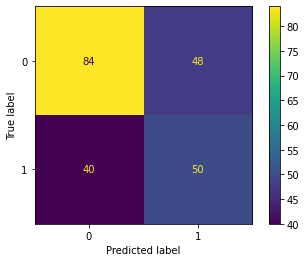

In [72]:
plot_confusion_matrix(knn_model, X_test, y_test)

#### Logistic Regression

In [73]:
logres_model = LogisticRegression(max_iter=1000)

In [74]:
logres_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
y_pred = logres_model.predict(X_test)

In [76]:
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
f1 = f1_score(y_test, y_pred, average="micro")

precision, recall, f1

(0.7657657657657657, 0.7657657657657657, 0.7657657657657657)

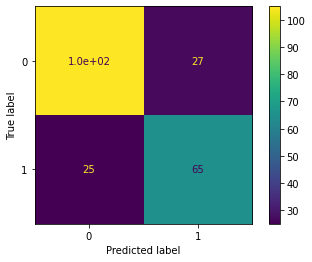

In [77]:
plot_confusion_matrix(logres_model, X_test, y_test)

Finding the 100 people in the training set with the highest probability of dying.

In [78]:
y_dec = logres_model.decision_function(X_train)

In [79]:
df_train_orig["Confidence"]=y_dec

In [80]:
bottom_100 = df_train_orig.sort_values(by="Confidence", ascending=True).head(100)

bottom_100

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Surname,Title,Given name,Survived,Confidence
609,3,male,29.0,8,2,69.5500,None,S,Sage,Mr,George,0,-5.154264
614,3,male,29.0,8,2,69.5500,None,S,Sage,Mr,Frederick,0,-5.150410
644,3,male,29.0,8,2,69.5500,None,S,Sage,Mr,Douglas,0,-5.042515
626,3,male,74.0,0,0,7.7750,None,S,Svensson,Mr,Johan,0,-4.461266
628,3,male,3.5,8,2,69.5500,None,S,Sage,Master,Thomas,0,-4.312211
...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,3,male,29.0,0,0,7.7375,None,Q,Kilgannon,Mr,Thomas,0,-2.565198
32,3,male,16.0,1,3,34.3750,None,S,Ford,Mr,William,0,-2.564268
473,3,male,28.0,0,0,7.8542,None,S,Olsson,Mr,Nils,0,-2.563268
99,3,male,29.0,0,0,7.7500,F38,Q,Tobin,Mr,Roger,0,-2.560699


In [81]:
bottom_100["Survived"][bottom_100["Survived"]==1].count()

7

# Conclusion

I trained following three models with training set (667 records):

1. Random Forest Classifier (Accuracy Score = 0.6486486486486487)
2. k Nearest Neighbors Classifier (k=13) (Accuracy Score = 0.6036036036036037)
3. Logistic Regression Classifier (max_iter=1000) (Accuracy Score = **0.7657657657657657**)

I found there was **no "Jack" onboard**.

I found 100 people with lowest survival chance. **Seven survived, though**.